<table> 
    <tr>
        <td  style="background-color:#ffffff;"><a href="https://qsoftware.lu.lv/index.php/qworld/" target="_blank"><img src="..\Images\qworld.jpg" width="70%" align="left"></a></td>
        <td style="background-color:#ffffff;" width="*"></td>
        <td  style="background-color:#ffffff;vertical-align:text-top;"><a href="https://qsoftware.lu.lv" target="_blank"><img src="..\Images\qturkey.png" width="50%" align="right"></a></td>        
    </tr></table>
<table><tr style="background-color:white;">
    <td>Follow Us (QWorld)</td>
    <td><a href="https://www.facebook.com/qworld19/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QWorld19" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QLatvia</td>
    <td><a href="https://www.facebook.com/QLatviaSoftware/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QLatviaSoftware" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QTurkey</td>
    <td><a href="https://www.facebook.com/groups/290363815207623/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/KuantumTurkiye" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    </tr></table>

### Embeddings

----------- Put Embeddings Content Here ------------------

###  Quantum Embeddings
https://pennylane.ai/qml/demos/tutorial_embeddings_metric_learning.html

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pennylane as qml
from pennylane import numpy as np
from pennylane import RX, RY, RZ, CNOT

In [2]:
def feature_encoding_hamiltonian(features, wires):

    for idx, w in enumerate(wires):
        RX(features[idx], wires=w)

def ising_hamiltonian(weights, wires, l):

        # ZZ coupling
        CNOT(wires=[wires[1], wires[0]])
        RZ(weights[l, 0], wires=wires[0])
        CNOT(wires=[wires[1], wires[0]])
        # local fields
        for idx, w in enumerate(wires):
            RY(weights[l, idx + 1], wires=w)

def QAOAEmbedding(features, weights, wires):

    repeat = len(weights)
    for l in range(repeat):
        # apply alternating Hamiltonians
        feature_encoding_hamiltonian(features, wires)
        ising_hamiltonian(weights, wires, l)
    # repeat the feature encoding once more at the end
    feature_encoding_hamiltonian(features, wires)

In [6]:
X = np.loadtxt("../data/embedding_metric_learning/X_antbees.txt", ndmin=2)  #1  pre-extracted inputs
Y = np.loadtxt("../data/embedding_metric_learning/Y_antbees.txt")  # labels
X_val = np.loadtxt(
    "../data/embedding_metric_learning/X_antbees_test.txt", ndmin=2
)  # pre-extracted validation inputs
Y_val = np.loadtxt("../data/embedding_metric_learning/Y_antbees_test.txt")  # validation labels

# split data into two classes
A = X[Y == -1]
B = X[Y == 1]
A_val = X_val[Y_val == -1]
B_val = X_val[Y_val == 1]

print(A.shape)
print(B.shape)

(83, 512)
(70, 512)


In [7]:
n_features = 2
n_qubits = 2 * n_features + 1

dev = qml.device("default.qubit", wires=n_qubits)

In [8]:
@qml.qnode(dev)
def swap_test(q_weights, x1, x2):

    # load the two inputs into two different registers
    QAOAEmbedding(features=x1, weights=q_weights, wires=[1, 2])
    QAOAEmbedding(features=x2, weights=q_weights, wires=[3, 4])

    # perform the SWAP test
    qml.Hadamard(wires=0)
    for k in range(n_features):
        qml.CSWAP(wires=[0, k + 1, 2 + k + 1])
    qml.Hadamard(wires=0)

    return qml.expval(qml.PauliZ(0))

In [9]:
def overlaps(weights, X1=None, X2=None):

    linear_layer = weights[0]
    q_weights = weights[1]

    overlap = 0
    for x1 in X1:
        for x2 in X2:
            # multiply the inputs with the linear layer weight matrix
            w_x1 = linear_layer @ x1
            w_x2 = linear_layer @ x2
            # overlap of embedded intermediate features
            overlap += swap_test(q_weights, w_x1, w_x2)

    mean_overlap = overlap / (len(X1) * len(X2))
    return mean_overlap

In [10]:
def cost(weights, A=None, B=None):

    aa = overlaps(weights, X1=A, X2=A)
    bb = overlaps(weights, X1=B, X2=B)
    ab = overlaps(weights, X1=A, X2=B)

    d_hs = -2 * ab + (aa + bb)

    return 1 - 0.5 * d_hs

In [11]:
# generate initial parameters for circuit
init_pars_quantum = np.random.normal(loc=0, scale=0.1, size=(4, 3))

# generate initial parameters for linear layer
init_pars_classical = np.random.normal(loc=0, scale=0.1, size=(2, 512))

init_pars = [init_pars_classical, init_pars_quantum]

In [12]:
optimizer = qml.RMSPropOptimizer(stepsize=0.01)
batch_size = 5
pars = init_pars

for i in range(2):

    # Sample a batch of training inputs from each class
    selectA = np.random.choice(range(len(A)), size=(batch_size,), replace=True)
    selectB = np.random.choice(range(len(B)), size=(batch_size,), replace=True)
    A_batch = [A[s] for s in selectA]
    B_batch = [B[s] for s in selectB]

    # Walk one optimization step
    pars = optimizer.step(lambda w: cost(w, A=A_batch, B=B_batch), pars)
    print("Step", i, "done.")

    # Print the validation cost every 10 steps
    if i % 5 == 0 and i != 0:
        cst = cost(pars, A=A_val, B=B_val)
        print("Cost on validation set {:2f}".format(cst))

Step 0 done.
Step 1 done.


In [15]:
pretrained_pars = np.load("../data/embedding_metric_learning/pretrained_parameters.npy",
                          allow_pickle=True)

print(pretrained_pars)

[array([[ 0.07892546,  0.18963997,  0.01267011, ..., -0.41917757,
         0.13794201, -0.31620719],
       [-0.49709026, -0.49160803, -0.16817771, ...,  0.35410417,
        -0.28687695,  0.25804757]])
 array([[ 1.28247918e-03, -2.53456415e-05, -2.53456415e-05],
       [ 1.55648560e-06,  1.65446338e-02,  1.55648553e-06],
       [ 8.12333186e-06, -1.99865981e-04,  6.71177010e-03],
       [-2.92851167e-03,  8.12333185e-06,  1.09834400e-03]])]


In [16]:
select = 10
cost_train = cost(pretrained_pars, A=A[:select], B=B[:select])
cost_val = cost(pretrained_pars, A=A_val[:select], B=B_val[:select])
print("Cost for pretrained parameters on training set:", cost_train)
print("Cost for pretrained parameters on validation set:", cost_val)

Cost for pretrained parameters on training set: 5.8432370360073094e-05
Cost for pretrained parameters on validation set: 5.8432370360073094e-05


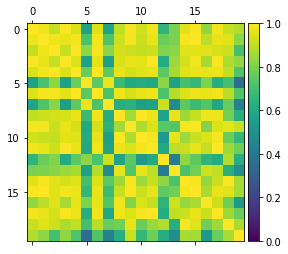

In [18]:
A_B = np.r_[A[:select], B[:select]]
gram_before = [[overlaps(init_pars, X1=[x1], X2=[x2]) for x1 in A_B] for x2 in A_B]

ax = plt.subplot(111)
im = ax.matshow(gram_before, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

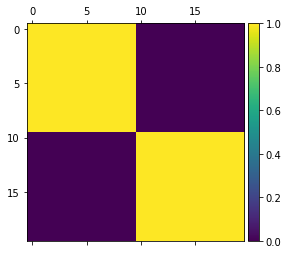

In [19]:
gram_after = [[overlaps(pretrained_pars, X1=[x1], X2=[x2]) for x1 in A_B] for x2 in A_B]

ax = plt.subplot(111)
im = ax.matshow(gram_after, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

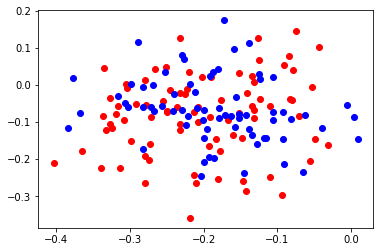

In [20]:
for a in A:
    intermediate_a = init_pars[0] @ a
    plt.scatter(intermediate_a[:][0], intermediate_a[:][1], c="red")

for b in B:
    intermediate_b = init_pars[0] @ b
    plt.scatter(intermediate_b[:][0], intermediate_b[:][1], c="blue")

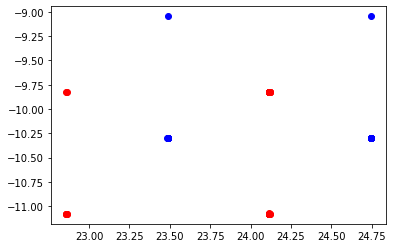

In [21]:
for a in A:
    intermediate_a = pretrained_pars[0] @ a
    plt.scatter(intermediate_a[:][0], intermediate_a[:][1], c="red")

for b in B:
    intermediate_b = pretrained_pars[0] @ b
    plt.scatter(intermediate_b[:][0], intermediate_b[:][1], c="blue")

In [22]:
x_new = A_val[0]

print(x_new.shape)

(512,)


In [23]:
n_samples = 200

prediction = 0
for s in range(n_samples):

    # select a random sample from the training set
    sample_index = np.random.choice(len(X))
    x = X[sample_index]
    y = Y[sample_index]

    # compute the overlap between training sample and new input
    overlap = overlaps(pretrained_pars, X1=[x], X2=[x_new])

    # add the label weighed by the overlap to the prediction
    prediction += y * overlap

# normalize prediction
prediction = prediction / n_samples
print(prediction)

-0.5549909955745074
